In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, rgb2hex
from matplotlib.cm import ScalarMappable
from modules.numeric import *

In [3]:
def chi(alpha, mu, nu):
    return -np.arctanh((mu*alpha)**nu)

def varphi(x, mu, nu):
    return mu*np.tanh(x)**nu

def phi(x, x0, alpha):
    assert alpha > -1
    mu = -1
    nu = 1 if alpha < 1 else -1
    dirichlet = 1 if alpha == 1 else varphi(x - chi(alpha, mu, nu), mu, nu)
    return dirichlet + np.tanh(x - x0) - 1

/tmp/ipykernel_11258/4231291127.py:2: RuntimeWarning: invalid value encountered in arctanh
  return -np.arctanh((mu*alpha)**nu)


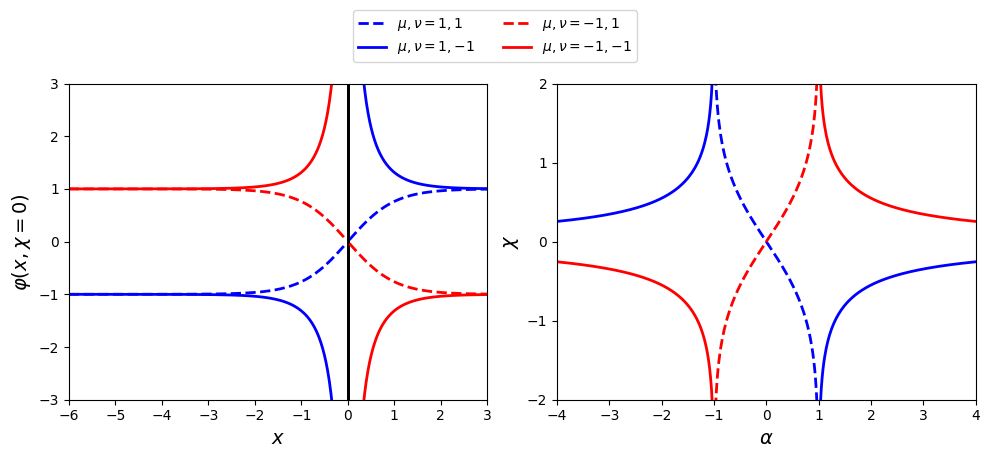

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(-6, 3, 250)
alpha = np.linspace(-4, 4, 500)
for mu in (1, -1):
    ax1.axvline(0, ls='-', c='k', lw=2)
    for nu in (1, -1):
        ax2.plot(alpha, chi(alpha, mu, nu), c={1:'b', -1:'r'}[mu], ls={1:'--', -1:'-'}[nu], lw=2, label=r'$\mu, \nu = {%s}, {%s}$'%(mu, nu))
        for i, xi in enumerate((x[x < 0], x[x > 0])):
            # ks = {'label':r'$\mu={%s}$, $\nu={%s}$'%(mu, nu)} if i == 0 else {}
            ax1.plot(xi, varphi(xi, mu, nu), c={1:'b', -1:'r'}[mu], ls={1:'--', -1:'-'}[nu], lw=2)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(-3, 3)

ax1.set_xlabel(r'$x$', fontsize=14)
ax1.set_ylabel(r'$\varphi(x,\chi=0)$', fontsize=14)
        

ax2.set_xlim(alpha.min(), alpha.max())
ax2.set_ylim(-2, 2)

ax2.set_xlabel(r'$\alpha$', fontsize=14)
ax2.set_ylabel(r'$\chi$', fontsize=14)

ax2.set_yticks([-2, -1, 0, 1, 2])
# ax2.xticks([0, 1, -1, 3, -3])

fig.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.15))

# ax1.legend(bbox_to_anchor=(1.35, 1))
# plt.show()
fig.tight_layout()
plt.show()

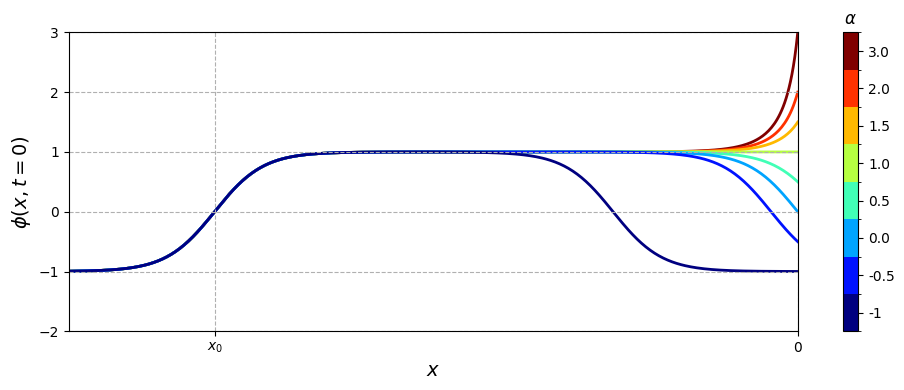

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))

x = np.linspace(-15, 0, 500)
x0 = -12
values = np.r_[-0.999, -0.5, 0, 0.5, 1, 1.5, 2, 3]
cmap = plt.get_cmap('jet', len(values))

for i, alpha in enumerate(values):
    ax.plot(x, phi(x, x0, alpha), c=cmap(i), lw=2, zorder=-i)

ax.set_ylim(-2, 3)
ax.set_xlim(x.min(), x.max())

ax.set_yticks((-2, -1, 0, 1, 2, 3))
ax.set_xticks([0, x0], [0, r'$x_0$'])

ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$\phi(x, t=0)$', fontsize=14)
ax.grid(ls='--')

dvs = np.r_[-1.5, values]
cbar = fig.colorbar(ScalarMappable(norm=BoundaryNorm(dvs, ncolors=len(dvs)), cmap=ListedColormap([cmap(i) for i in range(len(dvs))])), ax=ax)
cbar.ax.set_yticks((dvs[:-1] + dvs[1:])/2, (-1, *values[1:]))
cbar.ax.set_title(r'$\alpha$')

fig.tight_layout()
plt.show()

In [6]:
def kink_dirichlet(x0: float, v: float, alpha: float):
    gamma = 1/np.sqrt(1 - v**2)
    mu = -1
    nu = -1 if alpha > 1 else 1

    x, t = sp.symbols('x, t')
    z = gamma*(x - x0 - v*t)
    phi_kink = sp.tanh(z)
    phi_dirichlet = 1 if alpha == 1 else mu*sp.tanh(x - chi(alpha, mu, nu))**nu

    return Field((x, t), phi_dirichlet + phi_kink - 1)

In [7]:
L = 40
N = 1000 #int(L/40*1000)
DX = L/(N - 1)
DT = 0.7*DX
LAMB = 2
X0 = 10 #15*delta(lamb)/2 #L/3

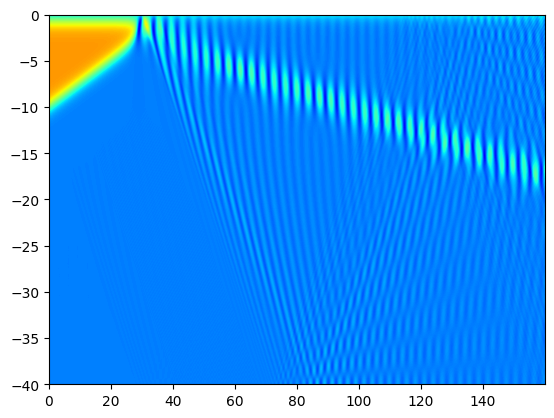

In [17]:
v = 0.25
alpha = -0.5

COLLIDER = KinkCollider(0, -L, N, (-X0, X0), DT, DX, order=4, H=alpha) 
field = kink_dirichlet(-X0, v, alpha=alpha)
Y0 = lambda x: field(x, 0)
Y0_dt = lambda x: field.diff(1)(x, 0)
y0 = np.stack((
    Y0(COLLIDER.x), 
    Y0_dt(COLLIDER.x)
))
t_final = L/v
t, Y = rk4_solve(COLLIDER.get_system(lamb=LAMB), y0, DT, t_final)
y = Y[:, 0]
plt.imshow(y.T, cmap='jet', vmin=-2, vmax=2, aspect='auto', extent=(t.min(), t.max(), COLLIDER.x.min(), COLLIDER.x.max()))